<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/explore_nbs/debug2MNIST_TPU_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FastAI XLA Extensions MNIST Demo

* updating pytorch xla install to use Pytorch XLA 1.6 release (official)
* update to use fastai to 2.0.0 and fastcore 1.0.0
since pytorch xla 1.6 install is not working with old version of fastai and fastcore
* update to use MNIST_TINY which I expect should be working with latest version of 
    * fastai 2.0.0 
    * fastcore 1.0.0, 
    * fastaix_xla_extensions 0.0.1 
    * pytorch xla 1.6 (official)

 as seen in [index demo notebook](https://github.com/butchland/fastai_xla_extensions/blob/master/nbs/index.ipynb)

* trains to 98.99 percent by using params found by `lr_find` - `lr_max=slice(5.75e-06, 0.021)`


## How to use

### Configure the Pytorch XLA package 

The Pytorch xla package requires an environment supporting TPUs (Kaggle kernels, GCP or Colab environments required)

If running on Colab, make sure the Runtime Type is set to TPU.


In [1]:
#hide_input
#colab
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [2]:
#hide
#colab
!curl -s https://course19.fast.ai/setup/colab | bash 

Updating fastai...
Done.


Install fastai2 and the fastai_xla_extensions packages

In [3]:
!pip install -Uqq fastcore==1.0.0

In [4]:
#hide_output
#colab
!pip install -Uqq fastai==2.0.0

In [5]:
#hide_output
#ci
!pip install -Uqq  git+https://github.com/butchland/fastai_xla_extensions.git

In [6]:
!pip install -Uqq cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.6-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 131.2MB 76kB/s 
     |████████████████████████████████| 61kB 2.6MB/s 


In [7]:
#hide_output
#colab
# VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION

In [8]:
!pip freeze | grep torch
!pip freeze | grep fastai2
!pip freeze | grep fastcore
!pip freeze | grep fastai-xla-extensions

torch==1.6.0+cu101
torch-xla==1.6
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.7.0+cu101
fastcore==1.0.0
fastai-xla-extensions==0.0.1


### Import the libraries
Import the fastai2 and fastai_xla_extensions libraries

In [1]:
#colab
import fastai_xla_extensions.core

**IMPORTANT: Make sure to import fastai_xla_extensions.core BEFORE importing fastai2 libraries** 

If you don't, fastai2 will not default to use tpu device but will instead use the cpu.

In [2]:
from fastai.vision.all import *

### Example
Build a MNIST classifier -- adapted from fastai course [Lesson 4 notebook](https://github.com/fastai/course-v4/blob/master/nbs/04_mnist_basics.ipynb)

Load MNIST dataset 

In [3]:
path = untar_data(URLs.MNIST_TINY)

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
path.ls()

(#5) [Path('valid'),Path('train'),Path('labels.csv'),Path('test'),Path('models')]

Create Fastai DataBlock


_Note that batch transforms are currently
set to none as they seem to slow the training
on the TPU (for investigation)._

In [6]:
datablock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(),
    get_y=parent_label,
    item_tfms=Resize(28),
    batch_tfms=[]
)

In [7]:
#colab
datablock.summary(path)

Setting-up type transforms pipelines
Found 1428 items
2 datasets of sizes 709,699
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_tiny/train/7/7959.png
    applying PILBase.create gives
      PILImage mode=RGB size=28x28
  Pipeline: parent_label -> Categorize -- {'vocab': (#2) ['3','7'], 'add_na': False}
    starting from
      /root/.fastai/data/mnist_tiny/train/7/7959.png
    applying parent_label gives
      7
    applying Categorize -- {'vocab': (#2) ['3','7'], 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=28x28, TensorCategory(1))


Setting up after_item: Pipeline: Resize -- {'size': (28, 28), 'method': 'crop', 'pad_mode': 'reflection'} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}

Building

Create the dataloader

In [8]:
dls = datablock.dataloaders(path)

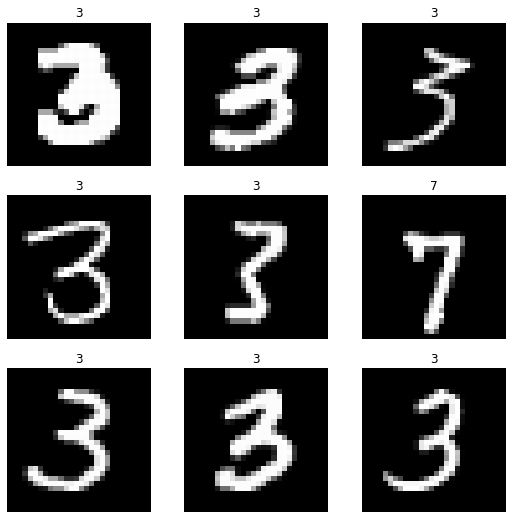

In [9]:
#colab
dls.show_batch()

Create a Fastai CNN Learner

In [10]:
#colab
learner = cnn_learner(dls, resnet18, metrics=accuracy, pretrained=False)
                      

In [11]:
learner.xla_opt

XLAOptCallback

In [12]:
learner.summary()

Sequential (Input shape: ['64 x 3 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 14 x 14    9,408      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 14 x 14    128        True      
________________________________________________________________
ReLU                 64 x 64 x 14 x 14    0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 7 x 7      0          False     
________________________________________________________________
Conv2d               64 x 64 x 7 x 7      36,864     True      
________________________________________________________________
BatchNorm2d          64 x 64 x 7 x 7      128        True      
________________________________________________________________
ReLU                 64 x 64 x 7 x 7      0          False     
___________________________________________________

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=9.12010818865383e-07)

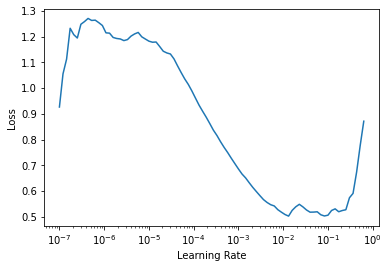

In [13]:
learner.lr_find()

In [14]:
# learner.fit(1)

In [15]:
learner.fit_one_cycle(10,lr_max=slice(5.75e-06, 0.021))

epoch,train_loss,valid_loss,accuracy,time
0,0.531556,2.548251,0.505007,00:03
1,0.310632,2.453043,0.512160,00:02
2,0.204246,2.688035,0.555079,00:02
3,0.163824,2.871352,0.640916,00:02
4,0.130442,0.291921,0.971388,00:02
5,0.110333,0.108019,0.988555,00:02
6,0.092553,0.113850,0.981402,00:02
7,0.074075,0.085396,0.987124,00:02
8,0.065357,0.072073,0.989986,00:02
9,0.054447,0.069750,0.989986,00:02


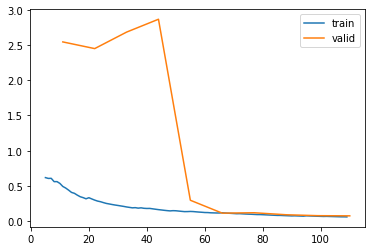

In [16]:
learner.recorder.plot_loss()

In [17]:
learner.save('stage-1')

Path('models/stage-1.pth')

In [18]:
learner.fit_one_cycle(5, lr_max=slice(1.5e-07,4e-03), wd=6e-6)

epoch,train_loss,valid_loss,accuracy,time
0,0.004427,0.065982,0.989986,00:02
1,0.004234,0.073568,0.988555,00:02
2,0.008028,0.084953,0.987124,00:02
3,0.007017,0.073827,0.989986,00:02
4,0.005250,0.066336,0.989986,00:02
